In [88]:
from pathlib import Path
from omlt.dependencies import onnx, onnx_available
import pyomo.environ as pe
import pytest
from omlt import OmltBlock
from omlt.gbt.gbt_formulation import GBTBigMFormulation
from omlt.gbt.model import GradientBoostedTreeModel
import lightgbm as lgb
import numpy as np
from onnxmltools.convert.lightgbm.convert import convert
from skl2onnx.common.data_types import FloatTensorType

In [89]:
X_small = np.array([[-0.68984135],
                    [0.91672866],
                    [-1.05874972],
                    [0.95275351],
                    [1.03796615],
                    [0.45117668],
                    [-0.14704376],
                    [1.66043409],
                    [-0.73972191],
                    [-0.8176603],
                    [0.96175973],
                    [-1.238874],
                    [-0.97492265],
                    [1.07121986],
                    [-0.95379269],
                    [-0.86546252],
                    [0.8277057],
                    [0.50486757],
                    [-1.38435899],
                    [1.54092856]])

y_small = np.array([[0.04296633],
                    [-0.78349216],
                    [0.27114188],
                    [-0.58516476],
                    [-0.15997756],
                    [-0.37529212],
                    [-1.49249696],
                    [1.56412122],
                    [0.18697725],
                    [0.4035928],
                    [-0.53231771],
                    [-0.02669967],
                    [0.36972983],
                    [0.09201347],
                    [0.44041505],
                    [0.46047019],
                    [-1.04855941],
                    [-0.586915],
                    [0.15472157],
                    [1.71225268]])

train_data = lgb.Dataset(X_small, label=y_small)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_trees': 5,
    'max_depth': 3,
    'min_data_in_leaf': 2,
    'random_state': 100,
    'verbose': -1
}

model_lgb = lgb.train(params, train_data)

In [90]:
float_tensor_type = FloatTensorType([None, model_lgb.num_feature()])
initial_types = [('float_input', float_tensor_type)]
onnx_model = convert(model_lgb, 
                        initial_types=initial_types, 
                        target_opset=8)

def write_onnx_to_file(onnx_model, path, file_name="output.onnx"):
    from pathlib import Path
    with open(Path(path) / file_name, "wb") as onnx_file:
        onnx_file.write(onnx_model.SerializeToString())
        return(f'Onnx model written to {onnx_file.name}')

write_onnx_to_file(onnx_model, r'C:\Users\yufengq\Desktop\RA\OMLT_ML')

'Onnx model written to C:\\Users\\yufengq\\Desktop\\RA\\OMLT_ML\\output.onnx'

In [91]:
model = onnx.load(".\output.onnx")

m = pe.ConcreteModel()

m.x = pe.Var(initialize=0)
m.y = pe.Var(initialize=0)
m.obj = pe.Objective(expr=1)
m.x.fix(0.5)

m.gbt = OmltBlock()
m.gbt.build_formulation(GBTBigMFormulation(GradientBoostedTreeModel(model)))

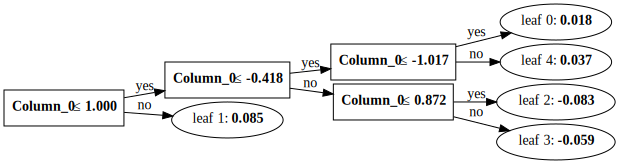

In [92]:
lgb.create_tree_digraph(model_lgb, 0)

In [93]:
assert len(m.gbt.z_l) == 25
assert len(m.gbt.y) == 4

assert len(m.gbt.single_leaf) == 5
assert len(m.gbt.left_split) == 20
assert len(m.gbt.right_split) == 20
assert len(m.gbt.var_lower) == 0
assert len(m.gbt.var_upper) == 0

In [94]:
@m.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.gbt.inputs[0]

@m.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.gbt.outputs[0]
status_1_bigm = pe.SolverFactory('gurobi').solve(m, tee=False)
pe.assert_optimal_termination(status_1_bigm)
solution_1_bigm = (pe.value(m.x), pe.value(m.y))
y_pred = model_lgb.predict(np.array(solution_1_bigm[0]).reshape(1, -1))
assert(y_pred[0] - solution_1_bigm[1] <= 1e-4)

    solver failure.
